In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
import numpy as np
from scipy.stats import norm
from dataclasses import dataclass

from utils import *
from config import *

from tqdm import tqdm


## How does this work?

This notebook executes a power analysis when the goal is to run discovery / elasticities tests for customer areas. Test setup is based on what was shared in the [Pricing Community VII](https://docs.google.com/presentation/d/17DcFaQTIVhFMLIZcWUR7lKg6VU-bidehiqQxXSUGJxQ/edit) regarding customer location. Since the analysis is not at the city level but rather at areas, we need to ensure that all areas must meet the sample size. 

The methodology here proposes an algorithm that takes area shapes, some session data and outputs a smaller, consolidated list of areas that should be analyzed together. The algorithm works assuming that if the smallest area, defined by the number of users making sessions, meets the sample size, all bigger areas will too. If an area does not meet the sample size, it must be merged with another area. The step-by-step process is the following:

- Load required data from BQ -> area shapes + session, conversion data at the user level + area indicator
- Initialize the tests parameters (n_variants, mde, alpha, power) plus a area mapping
    - The area mapping is extremely important. It keeps a log of which area should be merged with another one. For example, at iteration 0 we got the following mapping {"A":"A", "B":"B", "C":"C"}.\
      In the first iteration, it was decided that area "C" should be added to "A". thus, the new mapping is: {"A":"A", "B":"B", "C":"A"}.
- aggregate user level data to find the smallest area
- Using the aggregated data, find the smallest neighbor for each area.
- Calculate the required sample size for the intented MDE and compare it to the number of users in the area.
  - if the area has more user. Amazing, algorithm will stop. 
  - otherwise, merge the area to their smallest neighbor.
    - In the case the area doesn't have any neighbor, it will be merged with the next overall smallest area.
- Update the area mappings

Repeat until the algorithm has managed to find all areas that meet the sample size or it has exhausted all iterations.




### TO-DO
- ~~Parametrize sql arguments to allow different inputs~~ 
- Wrap the while in a function or what? 
- Persist aggregated shapes (BQ table, csv?)
- Remove non-exis

# Code

## Load data

In [5]:
connector = Connector(**BIGQUERY_CONFIG)

In [109]:
santa_cruz_input = {
    "shape_query" : QueryArgs(
        filename = "area-shapes.sql",
        params = {
            "country_code":"bo",
            "city":"Santa Cruz"
        }
    )

    , "session_query" : QueryArgs(
        filename = "sessions-with-location.sql",
        params = {
            "country_code":"bo",
            "city":"Santa Cruz",
            "entity_id":"PY_BO",
            "weeks_ago":2,
            "city_id":1,
            "asa_ids":[8]
        }
    )

    , "city_query" : QueryArgs(
        filename = "city-dh-shape.sql",
        params = {
            "entity_id":"PY_BO",
            "city_id":1
        }
    )
}


In [110]:
session_data = (
    connector
    .get_df_from_query(QueryHandler.build_query(santa_cruz_input["session_query"]))
    .pipe(convert_to_geopandas, "perseus_location")
    .drop(columns=["perseus_location"])
)



# # why i'm loading two shapes dataset? Can't I just bring the intersects of this two?
area_shapes = (
    pd.read_csv("data/bo-santa-cruz-shapes.csv")
    .pipe(convert_to_geopandas, "geo_shape")
    .drop(columns=["geo_shape"])
    
)


city_dh_shape = (
    connector
    .get_df_from_query(QueryHandler.build_query(santa_cruz_input["city_query"]))
    .pipe(convert_to_geopandas, "city_shape")
    .drop(columns=["city_shape"])
)








Job ID a7a21d9c-01b4-4c17-91eb-8edea39a3973 successfully executed: 100%|██████████|













































Downloading: 100%|██████████|






Job ID a8336fe0-d3a2-47aa-86a7-51b3f32bb5b1 successfully executed: 100%|██████████|






Downloading: 100%|██████████|


In [111]:
merged_areas = (
                area_shapes
                .query("to_merge")
                .dissolve(by="to_merge", aggfunc="sum", as_index=False)
                [["to_merge", "geometry"]]
                .rename(columns={"to_merge":"Name"})
                .replace({True:"Merged"})
)

areas_to_test = (
    pd.concat([
        area_shapes.query("~to_merge")
        , merged_areas
    ])
)

In [112]:
session_data_with_area = (
    areas_to_test
    .sjoin(session_data, predicate="contains")
    [["Name", "perseus_client_id", "n_sessions", "n_conversions"]]
    .groupby(["Name", "perseus_client_id"], as_index=False)
    [["n_sessions", "n_conversions"]]
    .sum()
)

In [113]:
session_data_with_area.n_conversions.sum()

197063

In [126]:
(
    session_data_with_area
    .pipe(aggregate_user_data_per_area, "Name")
    .assign(
        cvr = lambda df: df.total_conversion.div(df.total_session)
    )
)

,Name,avg_sessions,avg_conversions,total_session,total_conversion,n_users,cvr
6,Urubo,3.004783,0.904036,10051,3024,3345,0.300866
3,DM4,2.823329,0.855066,53999,16354,19126,0.302857
2,DM2,2.926612,0.900659,77245,23772,26394,0.307748
4,DM5,3.021153,0.884079,89550,26205,29641,0.29263
1,DM11,2.817297,0.866893,92875,28578,32966,0.307704
0,DM1,3.087988,0.909121,132416,38984,42881,0.294406
5,Merged,2.620466,0.67485,233549,60146,89125,0.257531


# Multiple Power Analysis

- Goal is to see how many areas we can have at different MDE levels

- How to run in parallel?

In [115]:
@dataclass
class MappingResults:
    sample_size_differences:dict
    is_feasible:bool
    power_params:PowerParams
    pop_share:float
    

def run_power_analysis_on_areas(df: pd.DataFrame, denom_col:str, num_col:str, power_params: PowerParams, pop_share:float, area_col:str, area_list:list[str]) -> dict[str, float]:
    """Run a power analysis on each area given the input.

    Args:
        df (pd.DataFrame): _description_
        denom_col (str): _description_
        num_col (str): _description_
        power_params (PowerParams): _description_
        pop_share (float): _description_
        area_col (str): _description_
        area_list (list[str]): _description_

    Returns:
        dict[str, float]: _description_
    """
    areas_with_delta_params = {x:aggregate_ratio_data(df.query(f"{area_col}==@x"), denom_col=denom_col, num_col=num_col) for x in area_list}
    areas_with_sample_size_difference = {key: math.ceil(val.sample_size * pop_share) - calculate_delta_method_sample_size(val, power_params) for key,val in areas_with_delta_params.items() }
    return MappingResults(
        areas_with_sample_size_difference
        , all([ x > 0 for x in areas_with_sample_size_difference.values()])
        , power_params
        , pop_share
    )
   

In [127]:
import itertools

mde_levels = [0.1, 0.25, 0.5, 0.75, 1]
n_variants = [2]
pop_shares = [1.0]





permutations = list(itertools.product(mde_levels, n_variants, pop_shares))
permutations_dict = [{
    "df":session_data_with_area, 
    "area_list":areas_to_test.Name.tolist(), 
    "power_params":PowerParams(mde=x[0]/100, n_variants=x[1]),
    "pop_share":x[2], 
    "area_col":"Name",
    "denom_col":"n_sessions",
    "num_col":"n_conversions"
    } 
    for x in permutations
]


test = permutations_dict[0]

df, area_list, power_params, pop_share, area_col, denom_col, num_col = test.values()

areas_with_delta_params = {x:aggregate_ratio_data(df.query(f"{area_col}==@x"), denom_col=denom_col, num_col=num_col) for x in area_list}
areas_with_sample_size_difference = {key: math.ceil(val.sample_size * pop_share) - calculate_delta_method_sample_size(val, power_params) for key,val in areas_with_delta_params.items() }




In [128]:
import joblib
results = joblib.Parallel(n_jobs=3)(joblib.delayed(run_power_analysis_on_areas)(**params) for params in tqdm(permutations_dict))








100%|██████████| 5/5 [00:00<00:00, 14.81it/s]


In [131]:
(
    session_data_with_area
    .pipe(aggregate_user_data_per_area, "Name")
    .assign(
        cvr = lambda df: df.total_conversion.div(df.total_session)
    )
)

,Name,avg_sessions,avg_conversions,total_session,total_conversion,n_users,cvr
6,Urubo,3.004783,0.904036,10051,3024,3345,0.300866
3,DM4,2.823329,0.855066,53999,16354,19126,0.302857
2,DM2,2.926612,0.900659,77245,23772,26394,0.307748
4,DM5,3.021153,0.884079,89550,26205,29641,0.29263
1,DM11,2.817297,0.866893,92875,28578,32966,0.307704
0,DM1,3.087988,0.909121,132416,38984,42881,0.294406
5,Merged,2.620466,0.67485,233549,60146,89125,0.257531


In [129]:
results

[MappingResults(sample_size_differences={'Urubo': -1953929, 'DM4': -2038554, 'DM11': -2171173, 'DM2': -2103547, 'DM1': -1920676, 'DM5': -1953268, 'Merged': -1871597}, is_feasible=False, power_params=PowerParams(mde=0.001, alpha=0.05, power=0.8, n_variants=2), pop_share=1.0),
 MappingResults(sample_size_differences={'Urubo': -309819, 'DM4': -310103, 'DM11': -319697, 'DM2': -314397, 'DM1': -271289, 'DM5': -287625, 'Merged': -224591}, is_feasible=False, power_params=PowerParams(mde=0.0025, alpha=0.05, power=0.8, n_variants=2), pop_share=1.0),
 MappingResults(sample_size_differences={'Urubo': -74946, 'DM4': -63182, 'DM11': -55200, 'DM2': -58804, 'DM1': -35662, 'DM5': -49676, 'Merged': 10696}, is_feasible=False, power_params=PowerParams(mde=0.005, alpha=0.05, power=0.8, n_variants=2), pop_share=1.0),
 MappingResults(sample_size_differences={'Urubo': -31451, 'DM4': -17455, 'DM11': -6219, 'DM2': -11472, 'DM1': 7973, 'DM5': -5611, 'Merged': 54267}, is_feasible=False, power_params=PowerParams(m

In [130]:
(
    pd.DataFrame([{
        "mde":x.power_params.mde*100,
        "n_variants":x.power_params.n_variants,
        "pop_share":x.pop_share,
        "is_feasible": x.is_feasible
    }
    for x in results #if x.is_feasible
    ])
    # .query("is_feasible")
    # .drop(columns=["mapping"])
    # .to_csv("istanbul-power-levels.csv", index=False)
)

,mde,n_variants,pop_share,is_feasible
0,0.10,2,1.0,False
1,0.25,2,1.0,False
2,0.50,2,1.0,False
3,0.75,2,1.0,False
4,1.00,2,1.0,False


# EDA results for chosen option

In [25]:
istanbul_power_params = PowerParams(mde=0.25/100, n_variants=5)
pop_share = 0.5

it_df = (
    session_data
    .copy()
)

# 
it_shapes = (
    area_shapes
    .sjoin(city_dh_shape, predicate="intersects")
    [area_shapes.columns]
)

mapping_results = run_power_analysis_per_area(
    it_df
    , it_shapes 
    , power_params=istanbul_power_params
    , pop_share=pop_share
    , verbose=False
    , show_charts=False
    , use_progress_bar=True
)

 83%|████████▎ | 30/36 [01:35<00:19,  3.20s/it]


In [26]:
mapping_df = (
            it_df
            .assign(
                area_map = lambda df: df.area_name.map(mapping_results.final_mapping)
        )  
        .groupby( ["area_map"], as_index=False)
        .agg(
                avg_sessions = ("n_sessions", "mean")
                ,  avg_conversions = ("n_conversions", "mean")
                ,  total_session = ("n_sessions", "sum")
                ,  total_conversion = ("n_conversions", "sum")
                ,  n_users = ("perseus_client_id", "count")
                , areas = ("area_name", set)
        )        
        .assign(
                cvr=lambda df: df.total_conversion.div(df.total_session)
                , n_areas = lambda df: df.areas.apply(len)
        )
)


mapping_shapes = (
        it_shapes
        .pipe(aggregate_shape_data_per_area, mapping_results.final_mapping, "area_map")
        .merge(mapping_df, left_on="area_map", right_on="area_map")
        .drop(columns=["city", "country_code", "area_name"])
        )


mapping_shapes.sort_values(by="n_users")


,area_map,geometry,avg_sessions,avg_conversions,total_session,total_conversion,n_users,areas,cvr,n_areas
1,Beşiktaş,"POLYGON ((29.04923 41.09682, 29.04539 41.08982...",4.049822,0.071777,591760,10488,146120,{Beşiktaş},0.017723,1
0,Beyoğlu,"MULTIPOLYGON (((28.98565 41.04361, 28.98702 41...",3.687532,0.155472,587741,24780,159386,"{Beyoğlu, Şişli}",0.042161,2
3,Kadıköy,"POLYGON ((29.09973 40.97865, 29.10453 40.97924...",3.887825,0.229676,1288635,76127,331454,"{Kadıköy, Maltepe}",0.059076,2
2,Eyüp,"POLYGON ((28.93736 41.04433, 28.93750 41.04430...",3.188058,0.31895,1377955,137858,432224,"{Eyüp, Bayrampaşa, Sultangazi, Sarıyer, Kağıth...",0.100045,9
5,Sancaktepe,"POLYGON ((29.43042 40.96891, 29.42842 40.96371...",3.284863,0.378056,1823109,209822,555003,"{Tuzla, Ümraniye, Çekmekoy, Pendik, Üsküdar, S...",0.11509,10
4,Küçükçekmece,"POLYGON ((28.69875 40.97375, 28.69847 40.97375...",3.275476,0.342901,2030962,212616,620051,"{Büyükçekmece, Bağcılar, Küçükçekmece, Silivri...",0.104687,12


In [35]:
#Original shapes
it_shapes = (
    area_shapes
    .sjoin(city_dh_shape, predicate="intersects")
    [area_shapes.columns]
)

# ax = (
(
    it_shapes
    .pipe(aggregate_shape_data_per_area, mapping_results.mapping_logs[0], "area_map")
    [["area_name", "geometry"]]
    .to_csv("data/istanbul-original-district-shape.csv", index=False)
    # .merge(mapping_df, left_on="area_map", right_on="area_map")
    # .drop(columns=["city", "country_code", "area_name"])
    # .plot(column="area_map", figsize=(15,8), legend=False, edgecolor="black", cmap="tab20")        
)
# ax.set_axis_off()
# ax.set_title("Original", size=20)

In [37]:
(
    mapping_shapes
    [["areas", "n_users", "avg_sessions", "cvr", "geometry"]]
    .assign(
        areas = lambda df: df["areas"].apply(list).apply(", ".join)
    )
    # .rename={"areas":"Aras"}
    .to_csv("data/istanbul-areas-data-0.25pp_50popshare-shapes.csv", index=False)
    # .style
    # .format(precision=3)

)

Text(0.5, 1.0, 'Merged')

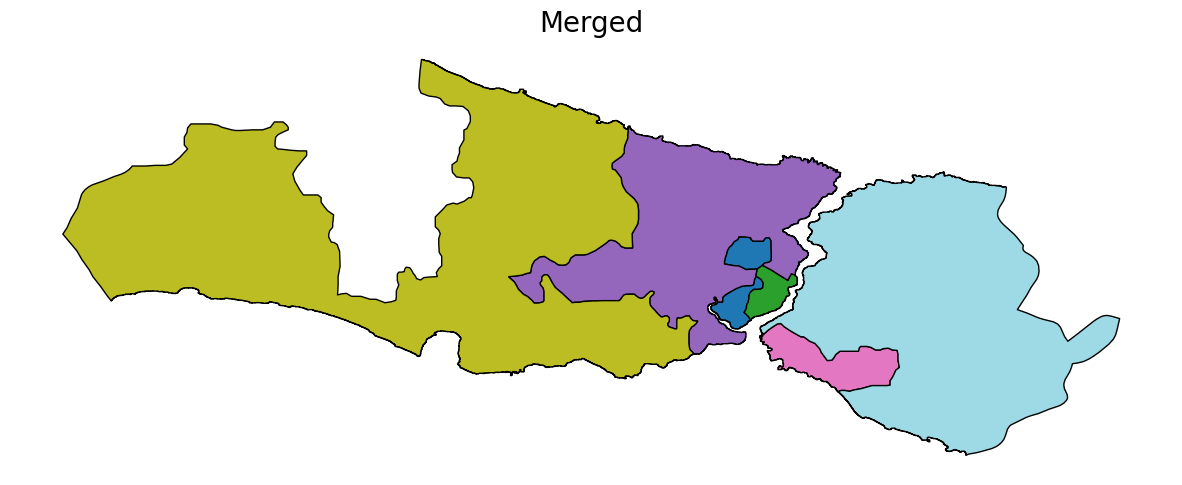

In [30]:
#Final Shape shapes
ax = mapping_shapes.plot(column="area_map", figsize=(15,8), legend=False, edgecolor="black", cmap="tab20")
ax.set_axis_off()
ax.set_title("Merged", size=20)